## Prerequisites
1. Creating a three ENV variables in the jupyter service :
    * GIT_TOKEN
    * AWS_ACCESS_KEY_ID
    * AWS_SECRET_ACCESS_KEY
2. clone this repo to your jupyter service - make sure you are running this notebook from the repo directory 


In [1]:
import mlrun

In [2]:
from mlrun.artifacts import DatasetArtifact,Artifact

In [3]:
project = mlrun.load_project('./')

In [4]:
project.save()

#### Project YAML

In [6]:
dataset = project.get_artifact('cancer-dataset')

In [7]:
job_function_run = project.run_function('fetch_data',inputs={'dataset' : dataset.target_path},local=True)

> 2022-12-12 09:58:57,181 [info] starting run fetch-data-fetch_data uid=5f653eb2023840ea9625161ef7e17bd4 DB=http://mlrun-api:8080
> 2022-12-12 09:59:00,444 [info] saving dataframe to s3


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
clone-test-shapira,...f7e17bd4,0,Dec 12 09:58:58,completed,fetch-data-fetch_data,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-5ffcc8fb9b-wbp64,dataset,,,dataset


> 2022-12-12 09:59:01,151 [info] run executed, status=completed


In [8]:
job_function = project.get_function('fetch_data').apply(mlrun.platforms.mount_s3())

In [10]:
job_function_run = job_function.run(inputs={'dataset' : dataset.target_path})

> 2022-12-12 09:59:01,195 [info] starting run fetch-data-fetch_data uid=401b6a7115ad474d9ed9887d5133b959 DB=http://mlrun-api:8080
> 2022-12-12 09:59:01,371 [info] Job is running in the background, pod: fetch-data-fetch-data-nz8jb
> 2022-12-12 09:59:05,317 [info] saving dataframe to s3
> 2022-12-12 09:59:05,972 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
clone-test-shapira,...5133b959,0,Dec 12 09:59:04,completed,fetch-data-fetch_data,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.2.1-rc3host=fetch-data-fetch-data-nz8jb,dataset,,,dataset


> 2022-12-12 09:59:07,665 [info] run executed, status=completed


In [11]:
job_function_run.outputs

{'dataset': 'store://artifacts/clone-test-shapira/fetch-data-fetch_data_dataset:401b6a7115ad474d9ed9887d5133b959'}

In [12]:
trainer = project.get_function('trainer').apply(mlrun.platforms.mount_s3())

In [13]:
trainer_run = trainer.run(inputs = {"dataset":job_function_run.outputs['dataset']},params = {"n_estimators": 100, "learning_rate": 1e-1, "max_depth": 3})

> 2022-12-12 09:59:07,706 [info] starting run trainer-train uid=67be7201d9d84ff7ab367aa2c25b16b2 DB=http://mlrun-api:8080
> 2022-12-12 09:59:07,881 [info] Job is running in the background, pod: trainer-train-6zv7b
> 2022-12-12 09:59:13,285 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
clone-test-shapira,...c25b16b2,0,Dec 12 09:59:10,completed,trainer-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.2.1-rc3host=trainer-train-6zv7b,dataset,n_estimators=100learning_rate=0.1max_depth=3,,model


> 2022-12-12 09:59:14,160 [info] run executed, status=completed


In [14]:
serving = project.get_function('serving').apply(mlrun.platforms.mount_s3())

In [15]:
serving_func = project.deploy_function('serving',models=[{'key':'cancer-classifier','model_path':trainer_run.outputs["model"], 'class_name':'mlrun.frameworks.sklearn.SklearnModelServer'}])

> 2022-12-12 09:59:14,188 [info] Starting remote function deploy
2022-12-12 09:59:14  (info) Deploying function
2022-12-12 09:59:14  (info) Building
2022-12-12 09:59:14  (info) Staging files and preparing base images
2022-12-12 09:59:14  (info) Building processor image
2022-12-12 10:00:29  (info) Build complete
2022-12-12 10:00:55  (info) Function deploy complete
> 2022-12-12 10:00:55,945 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-clone-test-shapira-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['clone-test-shapira-serving-clone-test-shapira.default-tenant.app.jmglmvqnganv.iguazio-cd1.com/']}


In [16]:
my_data = {"inputs"
           :[[
               1.371e+01, 2.083e+01, 9.020e+01, 5.779e+02, 1.189e-01, 1.645e-01,
               9.366e-02, 5.985e-02, 2.196e-01, 7.451e-02, 5.835e-01, 1.377e+00,
               3.856e+00, 5.096e+01, 8.805e-03, 3.029e-02, 2.488e-02, 1.448e-02,
               1.486e-02, 5.412e-03, 1.706e+01, 2.814e+01, 1.106e+02, 8.970e+02,
               1.654e-01, 3.682e-01, 2.678e-01, 1.556e-01, 3.196e-01, 1.151e-01]
            ]
}
serving_func.function.invoke("/", body=my_data)

> 2022-12-12 10:00:56,004 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-clone-test-shapira-serving.default-tenant.svc.cluster.local:8080/'}


{'id': '237a0b56-7823-48a0-a33c-629ab74a2560',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

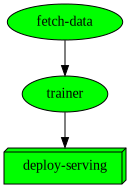

uid,start,state,name,parameters,results
...582045f4,Dec 12 10:01:28,completed,trainer,,
...b4d0c157,Dec 12 10:01:06,completed,fetch-data,,


70a2113c-552b-4847-a2be-654f2ef0fee3

In [17]:
project.run(workflow_path='workflow.py',watch=True)